## Evolutionary Methods
Using the techniques described in [this tutorial](https://becominghuman.ai/genetic-algorithm-for-reinforcement-learning-a38a5612c4dc), change the code in this notebook to use an evolutionary method instead.

In [13]:
%matplotlib inline
import json
import numpy as np
import random
import time
import math
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

## Define Game Environment
The idea in this FallingFruit game is that the user has to move to try to dodge the fruit. If they dodge it, they win and the game is over. If they get hit by it, they lose and the game is over. We are trying to teach the computer to play this game.

In [14]:
class FallingFruit(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_player_center = 1
        self.max_player_center = self.grid_size-2
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves player according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, player_center = self.state
        # move the player unless this would move it off the edge of the grid
        new_player_center = min(max(self.min_player_center, player_center + movement), self.max_player_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_player_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and player and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, player_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, player_center-1:player_center + 2] = 1  # draw 3-pixel player
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was dodged, -1 if it hit, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, player_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - player_center) <= 1:
                return -1 # it was hit by fruit
            else:
                return 1 # it dodged the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if episode is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        episode_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, episode_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            player center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        player_center = random.randint(self.min_player_center, self.max_player_center)
        self.state = np.asarray([fruit_x, fruit_y, player_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, episode_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            episode_over: boolean
        Add the states and episode over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, episode_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            episode_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i] = starting_observation[0]
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if episode_over: 
                # if the episode is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the episode is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets

##  Define Model and Evolutionary Functions

In [15]:
# parameters
num_actions = 3  # [move_left, stay, move_right]
hidden_size = 100
batch_size = 50
print_freq = 10
grid_size = 10
max_memory = 500


def gen_random_policy():
    # w = initializers.GlorotUniform() # use the default initializer
    # b = initializers.Zeros()
    
    # make model
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(Adam(), "mse")
    
    # randomize weights - not necessary because weights are initialized randomly
    # model.layers[0].set_weights([w(shape=(100, 100)).numpy(), b(shape=(100)).numpy()])
    # model.layers[1].set_weights([w(shape=(100, 100)).numpy(), b(shape=(100)).numpy()])
    # model.layers[2].set_weights([w(shape=(100, 100)).numpy(), b(shape=(100)).numpy()])    

    return model


def take_step(exp_replay, model, starting_observation):
    # get next action
    # find which action the model currently thinks is best from this state
    q = model.predict([starting_observation])
    action = np.argmax(q[0])

    # apply action, get rewards and new state
    new_observation, reward, episode_over = env.act(action)

    # store experience
    exp_replay.remember([starting_observation, action, reward, new_observation], episode_over)

    return new_observation, reward, episode_over
    
      
def run_episode(env, model):
    total_reward = 0
    env.reset()
    episode_over = False
    starting_observation = env.observe() # get initial input

    while not episode_over:
        starting_observation, reward, episode_over = \
            take_step(exp_replay, model, starting_observation)
        total_reward += reward
    
    return total_reward
      
        
def evaluate_policy(env, model, n_episodes=50):
    total_rewards = 0.0
    for _ in range(n_episodes):
        total_rewards += run_episode(env, model)
    return total_rewards / n_episodes if total_rewards > 0 else 0


def crossover(model1, model2):
    new_weights = model1.get_weights()
    weights2 = model2.get_weights()
    
    for i in [0, 2, 4]:
        for j in range(len(new_weights[i])):
            for k in range(len(new_weights[i][j])):
                rand = np.random.uniform()
                if rand > 0.5:
                    new_weights[i][j][k] = weights2[i][j][k]
    
    model1.set_weights(new_weights)
    
    return model1


def mutate(model, p=0.05):
    new_weights = model.get_weights()
    for i in [0, 2, 4]:
        for j in range(len(new_weights[i])):
            for k in range(len(new_weights[i][j])):
                rand = np.random.uniform()
                if rand < p:
                    new_weights[i][j][k] = np.random.normal(loc=0, scale=0.1732)
                    
    model.set_weights(new_weights)
    
    return model
     
    
def train(env, exp_replay, num_generations, num_policies):
    
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
        num_policies: integer, the number of policies which should be created
    '''
    
    rewards = []
    policy_pop = [gen_random_policy() for _ in range(num_policies)]
    for episode in range(1, num_generations+1):
        t = time.time()
        policy_scores = [evaluate_policy(env, p) for p in policy_pop]
        print('Generation %d : max score = %0.2f (time to evaluate : %d minutes %d seconds)' % (episode, max(policy_scores), math.floor((time.time() - t)/60), math.floor((time.time() - t)%60)))
        policy_ranks = list(reversed(np.argsort(policy_scores))) # sort by score
        elite_set = [policy_pop[x] for x in policy_ranks[:5]] # get top 5 policies
        select_probs = np.array(policy_scores) / np.sum(policy_scores) # give top policies higher chance of being crossed-over
        child_set = [crossover(
            policy_pop[np.random.choice(range(num_policies), p=select_probs)],
            policy_pop[np.random.choice(range(num_policies), p=select_probs)])
            for _ in range(num_policies - 5)]
        mutated_list = [mutate(p) for p in child_set]
        policy_pop = elite_set
        policy_pop += mutated_list
    
    policy_score = [evaluate_policy(env, p) for p in policy_pop]
    final_model = policy_pop[np.argmax(policy_score)]
    
    return final_model


def create_animation(model, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            q = model.predict([observation])
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Train and Assess Model

**How I Converted to use Evolutionary Methods**

To modify the FallingFruit game model to use evolutionary methods I used the structure described in the tutorial. I seperated `train_model()` into `run_episode()` and `evaluate_policy()`, created `crossover()` and `mutate()`, and of course modified the `train()` function to reflect the new methods. I more-or-less copied the code for the training function, but used that code and what parameters it expected to create or reshape the other functions.

**How the Evolutionary Methods Performed**

I ended up running 5 generations with 25 policies, and 50 episodes per policy evaluation. The model correctly moved the platform to avoid the fruit less than 1/5, or 80% of the time.

I chose to maximize episodes rather than policies or generations because I wanted the most accurate scores possible. These scores are used in the crossover function to optimize for higher-performing models, so the more granular the scores, the more the models \*should* improve.

I obtained higher scores of 1 (100%) using fewer generations, episodes, and policies, but these scores incorrectly represented the model. The model had learned to move the platform to the right of the grid in most situtations, which meant that it interacted with the fruit about 20% of the time, a sufficiently low probability that running ~5 episodes would often result in a score of 1.

The highest possible score is 1, where the fruit never hits the platform. Conversely, the lowest possible score is -1, where the fruit hits the platform every time; however, any negative numbers were converted to 0 so that the score could function as a probability for crossover.

The final model performs pretty well. The median score is 0.74, but we do see the final model successfully avoid the fruit 10 times in a row in the animation.

In [16]:
num_generations = 5
num_policies = 25

# Define environment/game
env = FallingFruit()
print("Defined environment")

# Initialize experience replay object
exp_replay = ExperienceReplay(max_memory=max_memory)
print("Initialized exp_replay")

print("Testing policies...")
print("=========================")
total_time_start = time.time()
final_model = train(env, exp_replay, num_generations, num_policies)
print("=========================")
print("Total time to train with %d generations and %d policies: %d minutes %d seconds" % (num_generations, num_policies, math.floor((time.time() - total_time_start)/60), math.floor((time.time() - total_time_start)%60)))

Defined environment
Initialized exp_replay
Testing policies...
Generation 1 : max score = 0.80 (time to evaluate : 4 minutes 9 seconds)
Generation 2 : max score = 0.68 (time to evaluate : 4 minutes 12 seconds)
Generation 3 : max score = 0.68 (time to evaluate : 4 minutes 3 seconds)
Generation 4 : max score = 0.64 (time to evaluate : 4 minutes 10 seconds)
Generation 5 : max score = 0.80 (time to evaluate : 4 minutes 12 seconds)
Total time to train with 5 generations and 25 policies: 25 minutes 7 seconds


In [19]:
final_score = evaluate_policy(env, final_model)
print("final score : %0.2f" % (final_score))

final score : 0.76


Rewards in Animation: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


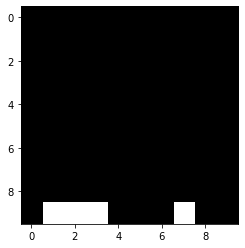

In [17]:
animation = create_animation(final_model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

In [18]:
final_model.save("")

INFO:tensorflow:Assets written to: assets
